# Transfer Learning on your Own Dataset

You will get to use the power of Transfer learning with **your own dataset**. So in this assignment you are going to retrain the pre-trained VGG16 Model with your own detectable objects. 

![](https://miro.medium.com/max/1000/0*xNjEPIZmPvKeqss6)

For doing so, you should :

* Generate a custom dataset, so take your own images from custom objects (or from the team members).  

* Be sure that you take the images from different angles and different distances, different lighting conditions and different backgrounds for each object. In other words, changing the environment where your objects are while training will lead to a better performance (generalization).

* Use at least 3 diffent opbjects (3 classes) and at most 10 classes where such dataset should have at least 50-100 images per class. (more images should lead to better detection performance) 

* Follow the workflow as [decribed before](https://keras.io/guides/transfer_learning/)

* Show the output of the different (training) steps and the resulting classification on unseen data and answer the related questions in the subsections below

---

### Use the following websites that take you trought all the steps of development.

The first page explains how to use the VGG-16 model with Keras to classify pre-tained images. 
> https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/





This second page explains the complete proces for classification of images using Keras, they start a problem desciption, data praparation, building a custom CNN model and then optimizing this model. After this they look at the same problem solving it with transfer learning. 

> https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/


You can start at the **"Explore Transfer Learning"** chapter, although you probably need to look back at earlier parts of this page.  

| NOTE: Finetuning by retraining all weights in the network as described in the workflow is Optional |
| --- |


```
Imad Hanzaz, Yannick Urselmann, Jaylong Verschuren
```

# Initialization

load all needed libraries and functions, 
check the previous tutorial how to correctly load keras and other modules

In [291]:
import tensorflow as tf
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import PIL
from pathlib import Path
import imghdr
from os import listdir
from numpy import asarray
from numpy import save


print("Current Tensorflow version used is: " + tf.__version__)

Current Tensorflow version used is: 2.11.0


### Create a variable to trigger training of the model or not.

This is done because the whole notebook can be run at once. If a model is trained already, it would be time consuming to create another model.

In [292]:
TrainModel = False
model_iteration = 4
# model_iteration is used in the title for saving and loading of the model.

# Load dataset & Plot a subset

load your dataset and show a plot of the subset of your data



- Store data dir and count the amount of images for batchsize later.

In [293]:
traintest_data_dir = pathlib.Path("./dataset/traintest_teammembers")

traintest_data_dir_count_png = len(list(traintest_data_dir.glob('*/*.png')))
traintest_data_dir_count_jpg = len(list(traintest_data_dir.glob('*/*.jpg')))
    
traintest_count = traintest_data_dir_count_png + traintest_data_dir_count_jpg
print('Train & test set batch size = ' + str(traintest_count))


Train & test set batch size = 175


- Check if all images for the dataset have correct file type.

In [294]:
image_extensions = [".png"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(traintest_data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

- Store batch size and image dimensions.

In [295]:
batch_size = traintest_count
img_height = 224
img_width = 224

- Take the images from the datapath and convert them to the train and test sets. the data is Split 80/20 , image size (224,224), and shuffled.

In [296]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    traintest_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    shuffle= True,
    image_size=(img_height, img_width),
    batch_size=traintest_count)


Found 175 files belonging to 3 classes.
Using 140 files for training.
Using 35 files for validation.


- Write the images and labels to seperate variables for both train and test sets.

In [297]:
for image_batch, labels_batch in train_ds:
    x_train = image_batch
    y_train = labels_batch

In [298]:
for image_batch, labels_batch in test_ds:
    x_test = image_batch
    y_test = labels_batch

- The class names are inferred from the folder names where the data is stores.

In [299]:
class_names_train = train_ds.class_names
print(class_names_train)

['imad', 'jaylong', 'yannick']


- Plot a image from the dataset as is.

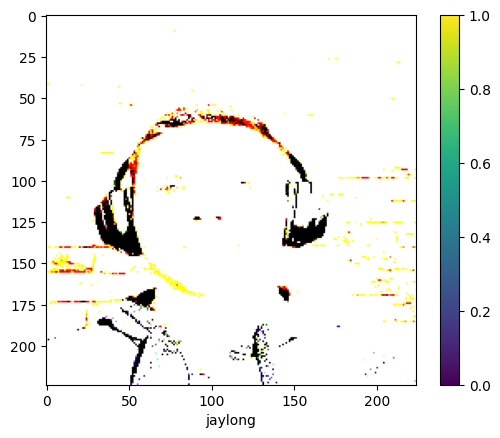

In [300]:
index = 100

plt.figure()
plt.imshow(x_train[index])
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names_train[y_train[index]])
plt.show()

# Prepare Data

pre-process your raw input data... rescale... normalize....

- First we change the labels to onehot as binairy is a better input than str for the model.
- Then we convert the images and labels to arrays.
- After which we use a preprocessing function which manipulates it with imagenet preprocessing.

In [301]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, 3)

x_train = np.array(x_train)
y_train = np.array(y_train)
y_train_onehot = np.array(y_train_onehot)

x_train = tf.keras.applications.imagenet_utils.preprocess_input(x_train, mode='torch')


In [302]:
y_test_onehot = tf.keras.utils.to_categorical(y_test, 3)

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test_onehot = np.array(y_test_onehot)

x_test = tf.keras.applications.imagenet_utils.preprocess_input(x_test, mode='torch')

- Plot of some images from the dataset after being preprocessed.

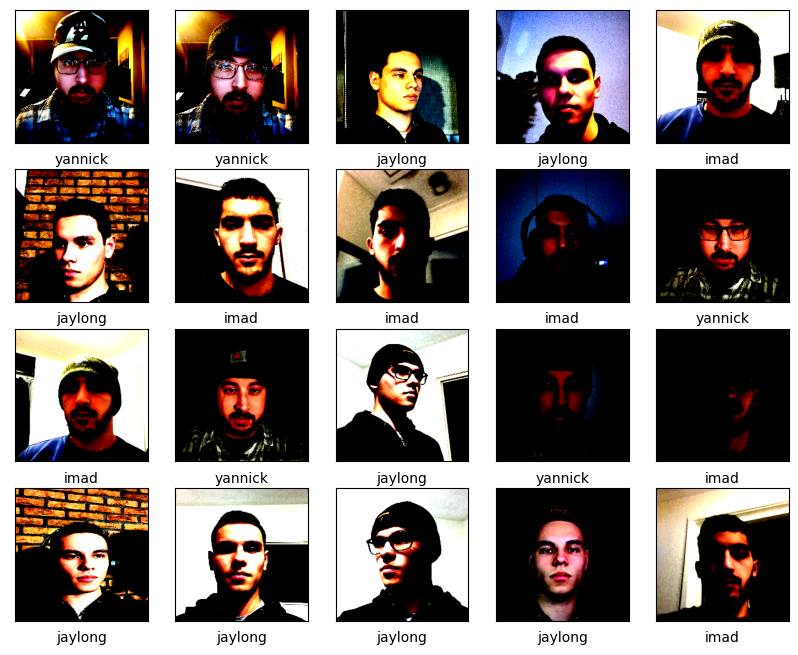

In [303]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names_train[y_train[i]])
plt.show()


## Define your Model

With Transfer learning you take a given network model withouth the last layers, you can take the suggested VGG-16 model as decribed on the given website and add the additional layers. 

**NOTE:**
That the Ouput layer should match your input dataset!



* How is your model constructed, how many trainable parameters does it have, and where are they located?
* The output model will use the VGG16 model as base with no trainable layers and the pre-trained imagenet provides the weigths.<br/> 
After the VGG16 layers a few additional layers will be added to fit the model to our use case.<br/> 
The dense layers will use relu as testing indicated a better result than with sigmoid.<br/> 
All trainable parameters are located in the dense layers which were added after the vgg16 as can be seen from the print(model.summary()) below.

In [304]:
if TrainModel == True:
    base_model = VGG16(weights='imagenet',include_top=False, input_shape=(224,224,3))   ## Loading VGG16 model
    base_model.trainable = False    ## Not trainable weights

    print(base_model.summary())


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

- Added layers after vgg16 base.

In [305]:
if TrainModel == True:
    flatten_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(50, activation='relu')
    drop_layer_1 = tf.keras.layers.Dropout(.2, input_shape=(img_height,img_width,3))
    dense_layer_2 = tf.keras.layers.Dense(20, activation='relu')
    prediction_layer = tf.keras.layers.Dense(3, activation='softmax')


    model = tf.keras.models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        drop_layer_1,
        dense_layer_2,
        prediction_layer
    ])
    
    print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_27 (Dense)            (None, 50)                1254450   
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_28 (Dense)            (None, 20)                1020      
                                                                 
 dense_29 (Dense)            (None, 3)                 63        
                                                                 
Total params: 15,970,221
Trainable params: 1,255,533


# Fit the Model

Fitting the model is the time consuming part, this depend on the complexity of the model and the amount of training data.<br/> 
With Transfer learning a lot of pre-trained parameters are now 'frozen', this will limit training time (or enables us to train more complex networks with the same processing performance, and so achieving better results)

* Which batch size and how many epochs give a good result?
* 3 Epochs was chosen as adding one mode results im a overfitted model (val_loss stays equal and doesn't improve).
* An earlystopping function found online is used to stop model.fit if the loss is no longer decreasing (how fast dependants on min_delta and patiance)

In [306]:
if TrainModel == True:
    checkpoint = tf.keras.callbacks.ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', patience=5,  restore_best_weights=True)

    reduce_learningrate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=3,
                                verbose=1,
                                min_delta=0.0001)

    callbacks_list = [es, reduce_learningrate]

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    history = model.fit(x_train, y_train_onehot, epochs=3, validation_data=(x_test, y_test_onehot),  callbacks=[callbacks_list])

Epoch 1/3
5/5 [==============================] - 11s 2s/step - loss: 1.0204 - accuracy: 0.5357 - val_loss: 0.3032 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 2/3
5/5 [==============================] - 10s 2s/step - loss: 0.2783 - accuracy: 0.8857 - val_loss: 0.2188 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 3/3
5/5 [==============================] - 10s 2s/step - loss: 0.0766 - accuracy: 0.9643 - val_loss: 0.0530 - val_accuracy: 1.0000 - lr: 0.0010


# Evaluate Model

Show the model accuracy after the training process ... 
* How accurate is your final model?
* The loss decreases quickly until the 3rd epoch while the accuracy increases quickly. This is probably because of the smaller amount of images in the dataset (~60 per class) and the low amount of classes.<br/> 
The final accuracy is 94,3% and 97,14% for the validation set.

In [307]:
if TrainModel:
    val_loss, val_acc = model.evaluate(x_test, y_test_onehot, batch_size= 1)
    print(f"Validated loss: {val_loss} , Validated Accuracy: {val_acc}")


35/35 [==============================] - 2s 71ms/step - loss: 0.0530 - accuracy: 1.0000
Validated loss: 0.05304175987839699 , Validated Accuracy: 1.0


# learning curves

Show the learning curves of your training sequence, of accuracy, value_accuracy and loss, value_loss



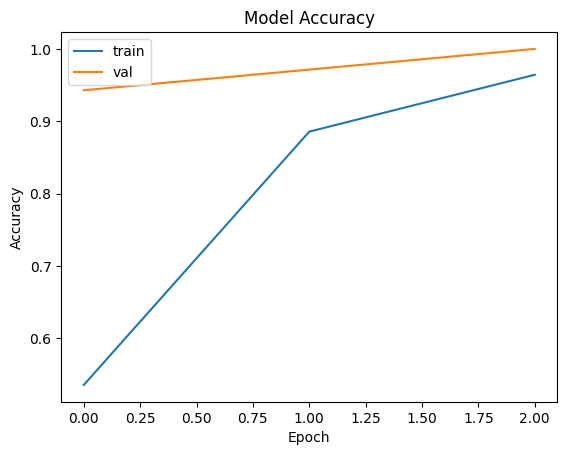

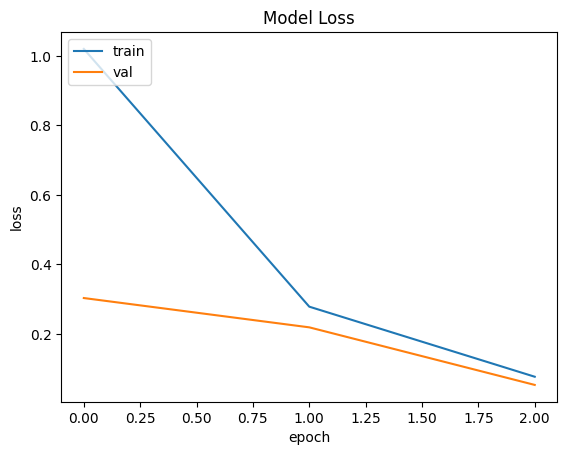

In [308]:
def plotAccuracyVsEpoch(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def plotLossVsEpoch(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

if TrainModel == True:
    plotAccuracyVsEpoch(history)
    plotLossVsEpoch(history)

# Save model

Save the model for later usage

- Save the model to specific folder and remove folder if already exists.

In [309]:
import shutil

if TrainModel == True:
    #save model
    save_path_model = 'saved_models/Teammembers_'+ str(model_iteration)
    # remove old account directory
    shutil.rmtree(save_path_model, ignore_errors=True)

    model.save(save_path_model)

INFO:tensorflow:Assets written to: saved_models/Teammembers_4\assets


INFO:tensorflow:Assets written to: saved_models/Teammembers_4\assets


# Evaluate Final Model

After training and saving the model you can deploy this model on any given input image. You can start a new application in where you import this model and apply it on any given imput images, so you can just load the model and don't need the timeconsuming training anymore.

- Load the layers saved in the previous step.

In [310]:
test_model = tf.keras.models.load_model(save_path_model)
probability_model = tf.keras.Sequential([test_model, tf.keras.layers.Softmax()])


# Make Prediction

We can use our saved model to make a prediction on new images that are not trained on... make sure the input images receive the same pre-processing as the images you trained on.

So fetch some images from the internet (similar classes, but not from your dataset), prepare them to fit your network and classify them. Do this for  **10 images per class** and show the results!

* How good is the detection on you real dataset? (show some statistics)<br/>
* The model is able to make a good distinction between the team members even at different angles, light levels and backgrounds <br/> With a Validated loss: 0.232 and Validated Accuracy: 0.939

- Determine the amount of images which are going to be predicted. this will later be used for the batch size.

In [320]:
prediction_data_dir = pathlib.Path("./dataset/predictions_team")

prediction_image_count_png = len(list(prediction_data_dir.glob('*/*.png')))
prediction_image_count_jpg = len(list(prediction_data_dir.glob('*/*.jpg')))
    
prediction_image_count = prediction_image_count_jpg + prediction_image_count_png
print('Prediction set batch size = ' + str(prediction_image_count))

Prediction set batch size = 33


- Load the images from prediction_data_dir.

In [321]:
batch_size = prediction_image_count

prediction_ds = tf.keras.utils.image_dataset_from_directory(
    prediction_data_dir,
    image_size=(img_height, img_width),
    #shuffle= False,
    batch_size=batch_size,
    class_names = ['imad', 'jaylong', 'yannick'],)

class_names_prediction = prediction_ds.class_names
print(class_names_prediction)

Found 33 files belonging to 3 classes.
['imad', 'jaylong', 'yannick']


- Examples of the images in the prediction set

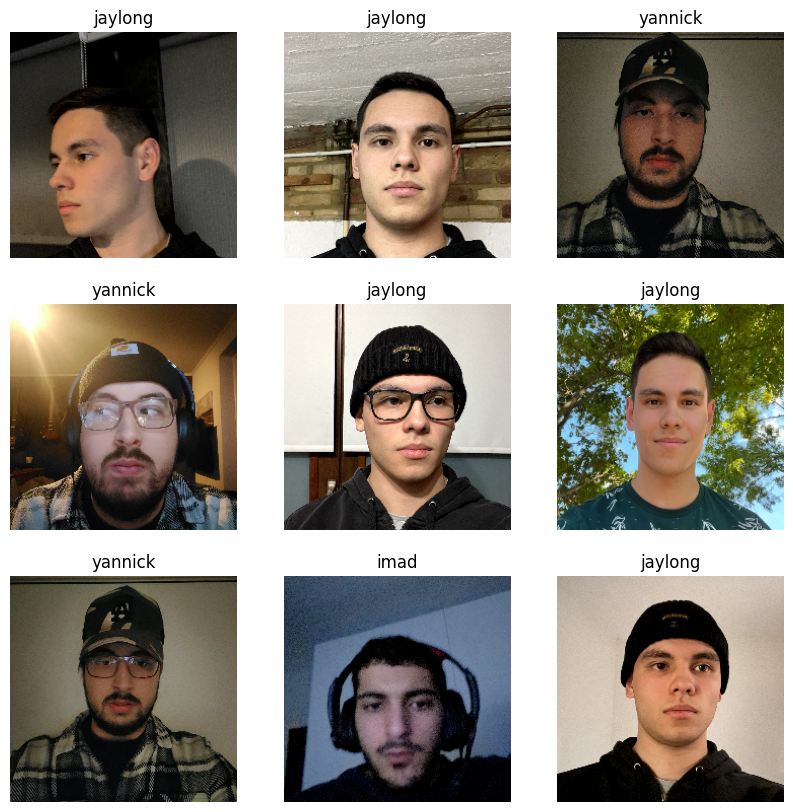

In [328]:
plt.figure(figsize=(10, 10))
for images, labels in prediction_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names_prediction[labels[i]])
        plt.axis("off")

- Seperate the images and labels.
- Make the labels onehot.
- Write the images and labels to arrays.
- Preproces the array with imagenet preprocessing.

In [330]:
for image_batch, labels_batch in prediction_ds:
    x_validation = image_batch
    y_validation = labels_batch

    y_validation_onehot = tf.keras.utils.to_categorical(y_validation, 3)

    x_validation = np.array(x_validation)
    y_validation = np.array(y_validation)
    y_validation_onehot = np.array(y_validation_onehot)
    
    x_validation = tf.keras.applications.imagenet_utils.preprocess_input(x_validation, mode='torch')


- Predict the batch of images of the teammembers.

In [331]:
predictSource = x_validation    # Used for debugging by swapping with the test set
realLabels = y_validation   # Used for debugging by swapping with the test set

predictions = probability_model.predict_on_batch(predictSource)
predictionLabels = np.argmax(predictions, axis=1)

- These functions from tensorflow.org plot the images with a graph of the predicted labels and real labels.

In [332]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

  thisplot[true_label].set_color('blue')

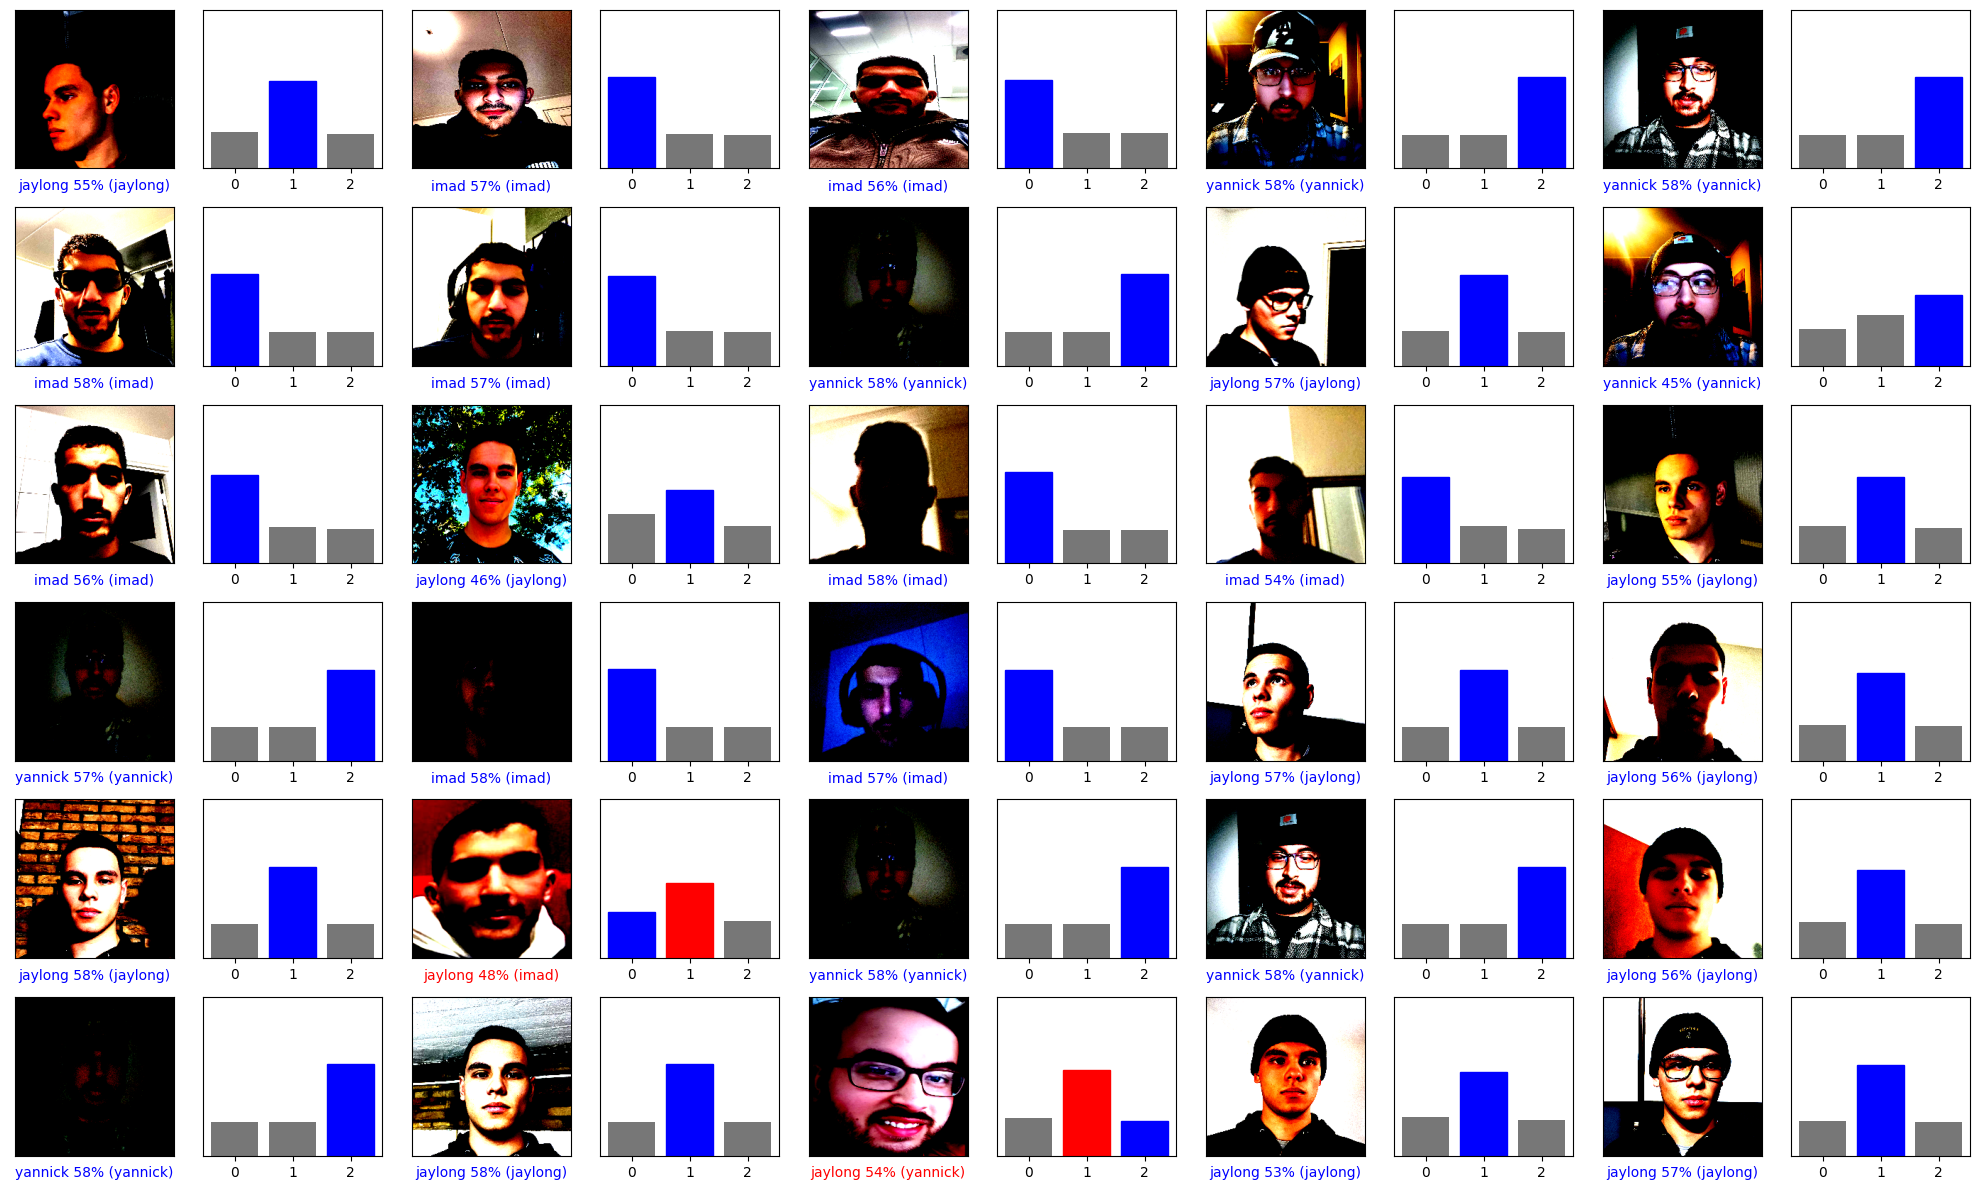

In [333]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 6
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], realLabels, predictSource)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], realLabels)
plt.tight_layout()
plt.show()

- A confusion matrix showing the predicted labels against the true labels.

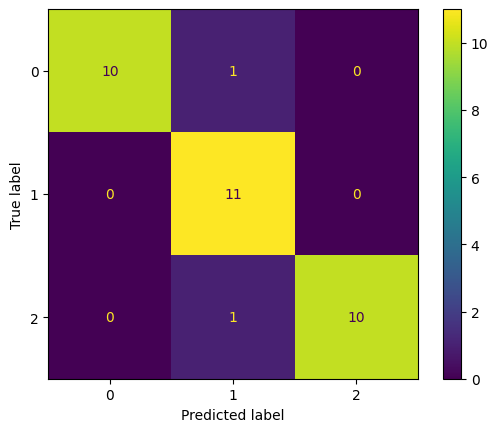

In [334]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(realLabels, predictionLabels)
ConfusionMatrixDisplay(cm).plot()

- The loss and accuracy from the prediction set.

In [335]:
val_loss, val_acc = model.evaluate(predictSource, tf.keras.utils.to_categorical(realLabels),batch_size= 1)
print(f"Validated loss: {val_loss} , Validated Accuracy: {val_acc}")

33/33 [==============================] - 2s 71ms/step - loss: 0.2319 - accuracy: 0.9394
Validated loss: 0.23188060522079468 , Validated Accuracy: 0.939393937587738


# Additional Questions
**Explain what your input object represents and how the result should be classified**<br>
*The input to the model are photo's from the teammembers (Imad, Jaylong, Yannick) of AIS7 group 2. The intended output is for the model to correctly classify each picture with the correct team member.

**Explain the pre-processing steps of the object training image(s) before you can feed it to the network.**<br>
- Resize image to (224,224) as from VGG16
- Encode the image labels to onehot.
- Writing the images to an array and same with labels.
- Preprocess the arrays with the tf.keras.applications.imagenet_utils.preprocess_input.


**What features do you think are extracted (relevant)?**<br>
- Nose, eyebrow distance, mouth size and shape of head.

**Show (in report and video) how accurate your predicted model is, how does your detection behave in other unseen situations? Also explain in what situation and why it does (not) perform well Supported your statements by measurement data!**<br>
- From the prediction dataset a accuracy of 93,9% was found.
- The detection works good with different light levels, backgrounds, angles and even with glases and hats (can be seen in the plot above the confusion matrix).
- The models seems to have less accuracy with different distances between the camera (subject is closer or farther from the camera then most of the dataset). May be due to distortion from the lens (can be seen in the plot above the confusion matrix).

**Explain the parameters that you used for re-training this network?**<br>
* Because of the good results, we did not retrain the network because the validated accuracy and validated loss were up to our needs.

**This example uses a custom (but pre-trained) network architecture, explain how it works and why it is build up this way?**<br>
* "VGG16 is object detection and classification algorithm which is able to classify 1000 images of 1000 different categories with 92.7% accuracy". Therefore we can use this pre-trained network for the first layers of our CNN model and adapt the network to our needs in terms of output classes. The input shape is always 224,224 so the first layers don't need to be adjusted.

## Finetuning
Finetuning by retraining all weights in the network as described in the workflow is Optional, but this will lead to a better accuracy of your final model,